<a href="https://colab.research.google.com/github/Cole-Krudwig/Time-Series-Predictions/blob/main/Stock_Predictor_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from google.colab import files

import io

# upload data
uploaded = files.upload()

# read data
data = pd.read_csv(io.BytesIO(uploaded['AMZN.csv']))
print(data)

Saving AMZN.csv to AMZN.csv
           Date        Open        High         Low       Close   Adj Close  \
0    2022-08-29  129.899994  131.949997  128.770004  129.789993  129.789993   
1    2022-08-30  131.250000  132.070007  126.849998  128.729996  128.729996   
2    2022-08-31  129.449997  130.589996  126.739998  126.769997  126.769997   
3    2022-09-01  126.000000  128.020004  123.660004  127.820000  127.820000   
4    2022-09-02  129.500000  131.380005  126.389999  127.510002  127.510002   
..          ...         ...         ...         ...         ...         ...   
245  2023-08-21  133.740005  135.190002  132.710007  134.679993  134.679993   
246  2023-08-22  135.080002  135.649994  133.729996  134.250000  134.250000   
247  2023-08-23  134.500000  135.949997  133.220001  135.520004  135.520004   
248  2023-08-24  136.399994  136.779999  131.830002  131.839996  131.839996   
249  2023-08-25  132.470001  133.869995  130.580002  133.259995  133.259995   

       Volume  
0    48

In [ ]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2022-08-29,129.789993
1,2022-08-30,128.729996
2,2022-08-31,126.769997
3,2022-09-01,127.820000
4,2022-09-02,127.510002
...,...,...
245,2023-08-21,134.679993
246,2023-08-22,134.250000
247,2023-08-23,135.520004
248,2023-08-24,131.839996


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

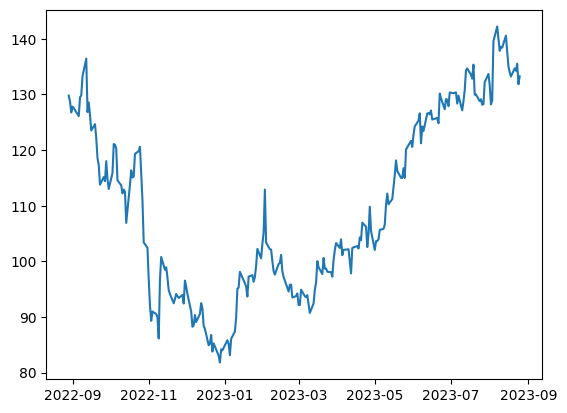

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [ ]:
# create lookback for previous closes
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2022-09-08,129.820007,129.479996,126.110001,127.510002,127.820000,126.769997,128.729996,129.789993
2022-09-09,133.270004,129.820007,129.479996,126.110001,127.510002,127.820000,126.769997,128.729996
2022-09-12,136.449997,133.270004,129.820007,129.479996,126.110001,127.510002,127.820000,126.769997
2022-09-13,126.820000,136.449997,133.270004,129.820007,129.479996,126.110001,127.510002,127.820000
2022-09-14,128.550003,126.820000,136.449997,133.270004,129.820007,129.479996,126.110001,127.510002
...,...,...,...,...,...,...,...,...
2023-08-21,134.679993,133.220001,133.979996,135.070007,137.669998,140.570007,138.410004,138.559998
2023-08-22,134.250000,134.679993,133.220001,133.979996,135.070007,137.669998,140.570007,138.410004
2023-08-23,135.520004,134.250000,134.679993,133.220001,133.979996,135.070007,137.669998,140.570007


In [ ]:
# convert chart to numpy array
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[129.820007, 129.479996, 126.110001, ..., 126.769997, 128.729996,
        129.789993],
       [133.270004, 129.820007, 129.479996, ..., 127.82    , 126.769997,
        128.729996],
       [136.449997, 133.270004, 129.820007, ..., 127.510002, 127.82    ,
        126.769997],
       ...,
       [135.520004, 134.25    , 134.679993, ..., 135.070007, 137.669998,
        140.570007],
       [131.839996, 135.520004, 134.25    , ..., 133.979996, 135.070007,
        137.669998],
       [133.259995, 131.839996, 135.520004, ..., 133.220001, 133.979996,
        135.070007]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[0.58940418, 0.57814554, 0.4665563 , ..., 0.48841047, 0.5533111 ,
        0.58841034],
       [0.70364249, 0.58940418, 0.57814554, ..., 0.52317878, 0.48841047,
        0.5533111 ],
       [0.80894027, 0.70364249, 0.58940418, ..., 0.51291395, 0.52317878,
        0.48841047],
       ...,
       [0.7781458 , 0.73609269, 0.75033087, ..., 0.76324524, 0.84933765,
        0.94536444],
       [0.65629123, 0.7781458 , 0.73609269, ..., 0.72715216, 0.76324524,
        0.84933765],
       [0.70331106, 0.65629123, 0.7781458 , ..., 0.70198676, 0.72715216,
        0.76324524]])

In [ ]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((243, 7), (243,))

In [ ]:
X = dc(np.flip(X, axis=1))
X

array([[0.58841034, 0.5533111 , 0.48841047, ..., 0.51291395, 0.4665563 ,
        0.57814554],
       [0.5533111 , 0.48841047, 0.52317878, ..., 0.4665563 , 0.57814554,
        0.58940418],
       [0.48841047, 0.52317878, 0.51291395, ..., 0.57814554, 0.58940418,
        0.70364249],
       ...,
       [0.94536444, 0.84933765, 0.76324524, ..., 0.70198676, 0.75033087,
        0.73609269],
       [0.84933765, 0.76324524, 0.72715216, ..., 0.75033087, 0.73609269,
        0.7781458 ],
       [0.76324524, 0.72715216, 0.70198676, ..., 0.73609269, 0.7781458 ,
        0.65629123]])

In [ ]:
split_index = int(len(X) * 0.95)

split_index

230

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230, 7), (13, 7), (230,), (13,))

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((230, 7, 1), (13, 7, 1), (230, 1), (13, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([230, 7, 1]),
 torch.Size([13, 7, 1]),
 torch.Size([230, 1]),
 torch.Size([13, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
train_dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
num_stacked_layers = 1000
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = 0.0
    print('Train Loss: {0:.3f}'.format(loss))

def test_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Test Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('__________________________________________________')
    print()

In [ ]:
def train_test_loop():
  train_one_epoch()
  test_one_epoch()

In [ ]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_test_loop()

Epoch: 1
Train Loss: 0.269
Test Loss: 0.897
__________________________________________________

Epoch: 2
Train Loss: 0.351
Test Loss: 0.910
__________________________________________________

Epoch: 3
Train Loss: 0.479
Test Loss: 0.922
__________________________________________________

Epoch: 4
Train Loss: 0.517
Test Loss: 0.931
__________________________________________________

Epoch: 5
Train Loss: 0.477
Test Loss: 0.934
__________________________________________________

Epoch: 6
Train Loss: 0.295
Test Loss: 0.934
__________________________________________________

Epoch: 7
Train Loss: 0.271
Test Loss: 0.935
__________________________________________________

Epoch: 8
Train Loss: 0.287
Test Loss: 0.930
__________________________________________________

Epoch: 9
Train Loss: 0.287
Test Loss: 0.929
__________________________________________________

Epoch: 10
Train Loss: 0.350
Test Loss: 0.926
__________________________________________________

Epoch: 11
Train Loss: 0.251
Test Loss: 

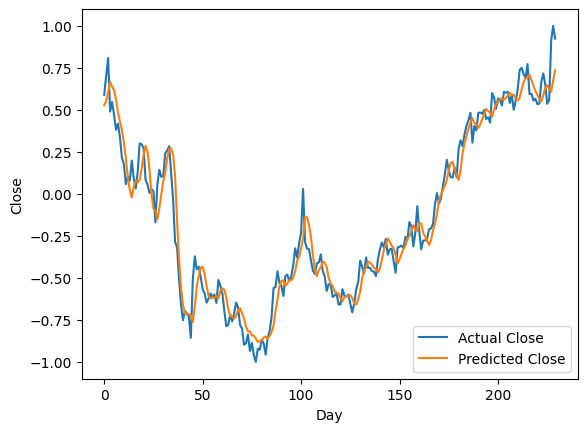

In [ ]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

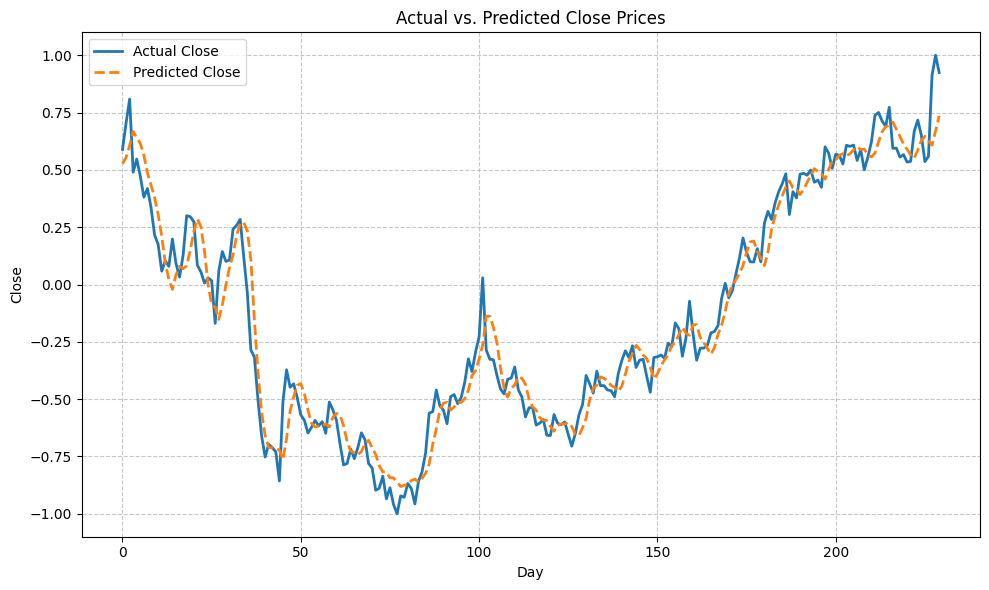

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y_train, label='Actual Close', linewidth=2)
ax.plot(predicted, label='Predicted Close', linestyle='dashed', linewidth=2)

# Set labels and title
ax.set_xlabel('Day')
ax.set_ylabel('Close')
ax.set_title('Actual vs. Predicted Close Prices')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()  # Ensure labels fit within the figure
plt.show()

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([127.93440203, 128.7483785 , 130.33010949, 132.17949144,
       131.31894381, 130.61867356, 129.03305444, 126.71632193,
       125.12637006, 123.45717595, 121.24515024, 118.38554295,
       114.85958213, 112.7185589 , 111.3893892 , 113.29580269,
       114.42376008, 114.09431259, 114.50867522, 116.53501885,
       118.98017037, 120.66760449, 119.61759422, 116.40844761,
       112.01518759, 109.38801353, 109.05586775, 107.42357172,
       109.35033219, 111.97903203, 114.23367911, 115.9156199 ,
       118.42784886, 120.05452286, 120.20461458, 119.06947676,
       115.28567935, 107.29628046, 100.39075412,  95.22163975,
        92.11597052,  90.56049161,  90.49336736,  90.44845225,
        90.20932144,  88.95348417,  91.72322616,  95.34993005,
        97.22665402,  98.7604458 ,  98.96559688,  97.65220448,
        95.48993154,  93.74085615,  93.25793057,  93.37187619,
        93.39034841,  93.67247186,  93.25624031,  94.55205692,
        95.03915324,  94.82782976,  93.40653815,  91.30

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([129.8200066 , 133.27000398, 136.4499977 , 126.82      ,
       128.55000286, 126.27999901, 123.52999918, 124.66000414,
       122.1900019 , 118.54000117, 117.30999791, 113.779999  ,
       115.15000206, 114.41000402, 118.01000222, 114.80000306,
       113.00000002, 115.87999716, 121.08999584, 120.94999705,
       120.30000338, 114.55999809, 113.66999799, 112.209999  ,
       112.900002  , 112.52999898, 106.90000213, 113.79000103,
       116.36000079, 115.06999995, 115.2499999 , 119.32000015,
       119.8200002 , 120.59999783, 115.66000392, 110.95999899,
       103.41000427, 102.44000217,  96.7900017 ,  92.12000265,
        89.30000298,  90.98000286,  90.52999858,  89.98000276,
        86.13999892,  96.62999613, 100.7900012 ,  98.48999844,
        98.94000182,  97.12000315,  94.8499975 ,  94.13999972,
        92.45999984,  93.19999743,  94.12999678,  93.41000327,
        93.94999615,  92.4199989 ,  96.54000032,  95.49999928,
        94.12999678,  91.01000267,  88.25000081,  88.45

In [ ]:
import torch

recent = 100
recent_closes = shifted_df['Close'].tail(recent).values
# Assuming you have already loaded and preprocessed your data
# input_data is your input data for prediction (shape: [batch_size, sequence_length, input_size])

# Set model to evaluation mode
model.eval()

# Convert input data to PyTorch tensor and move to the same device as the model
input_tensor = torch.tensor(recent_closes, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)

# Make predictions
with torch.no_grad():
    predicted_price = model(input_tensor)

# Since your model outputs a single value, you can directly extract it
predicted_price = predicted_price.item()

# Print the predicted price
print("Predicted Price:", predicted_price)


Predicted Price: 0.4711816608905792


In [ ]:
recent = 100
recent_closes = shifted_df['Close'].tail(recent).values
print(recent_closes)

predicted_price_changes_7days = []
predicted_price_7days = []

with torch.no_grad():
  input_tensor = torch.tensor(recent_closes, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)
  prediction = model(input_tensor).item()
  predicted_price_changes_7days.append(prediction)
  first_price = (predicted_price_changes_7days[0] + 1) * recent_closes[-1]
  predicted_price_7days.append(first_price)
  recent_closes = np.append(recent_closes, predicted_price_7days[0])

  for i in range(6):
    input_tensor = torch.tensor(recent_closes, dtype=torch.float32).unsqueeze(0).unsqueeze(2).to(device)
    prediction = model(input_tensor).item()

[103.949997 101.099998 102.059998 102.169998  99.919998  97.830002
 102.400002 102.510002 102.739998 102.300003 104.300003 103.809998
 106.959999 106.209999 102.57     104.980003 109.82     105.449997
 102.050003 103.629997 103.650002 104.       105.660004 105.830002
 106.620003 110.190002 112.18     110.260002 111.199997 113.400002
 115.5      118.150002 116.25     115.010002 114.989998 116.75
 115.       120.110001 121.660004 120.580002 122.769997 124.25
 125.300003 126.610001 121.230003 124.25     123.43     126.57
 126.660004 126.419998 127.110001 125.489998 125.779999 124.830002
 130.149994 129.330002 127.330002 129.179993 129.039993 127.900002
 130.360001 130.220001 130.380005 128.360001 129.779999 127.129997
 128.779999 130.800003 134.300003 134.679993 133.559998 132.830002
 135.360001 129.960007 130.       128.800003 129.130005 128.149994
 128.25     132.210007 133.679993 131.690002 128.210007 128.910004
 139.570007 142.220001 139.940002 137.850006 138.559998 138.410004
 140.57